In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import theano
# By convention, the tensor submodule is loaded as T
import theano.tensor as T

In [2]:
foo = T.scalar('foo')
bar = foo**2

In [5]:
print theano.pp(bar)
print bar.type
print type(bar)

(foo ** TensorConstant{2})
TensorType(float64, scalar)
<class 'theano.tensor.var.TensorVariable'>


In [6]:
f = theano.function([foo], bar)
print f(3)

9.0


In [8]:
print bar.eval({foo: 4})

16.0


In [9]:
def square(x):
    return x**2
bar = square(foo)
print bar.eval({foo: 5})

25.0


In [10]:
A = T.matrix('A')
x = T.vector('x')
b = T.vector('b')
y = T.dot(A, x) + b
z = T.sum(A**2)

b_default = np.array([0, 0], dtype=theano.config.floatX)
linear_mix = theano.function([A, x, theano.Param(b, default=b_default)], [y, z])

In [12]:
print linear_mix(np.array([[1, 2, 3],
                           [4, 5, 6]], dtype=theano.config.floatX), #A
                 np.array([1, 2, 3], dtype=theano.config.floatX), #x
                 np.array([4, 5], dtype=theano.config.floatX)) #b
# Using the default value for b
print linear_mix(np.array([[1, 2, 3],
                           [4, 5, 6]]), #A
                 np.array([1, 2, 3])) #x

[array([ 18.,  37.]), array(91.0)]
[array([ 14.,  32.]), array(91.0)]


In [13]:
shared_var = theano.shared(np.array([[1, 2], [3, 4]], dtype=theano.config.floatX))
print shared_var.type()

<TensorType(float64, matrix)>


In [14]:
shared_var.set_value(np.array([[3, 4], [2, 1]], dtype=theano.config.floatX))
print shared_var.get_value()

[[ 3.  4.]
 [ 2.  1.]]


In [15]:
shared_squared = shared_var**2
function_1 = theano.function([], shared_squared)
print function_1()

[[  9.  16.]
 [  4.   1.]]


In [16]:
subtract = T.matrix('subtract')

function_2 = theano.function([subtract], shared_var, updates={shared_var: shared_var - subtract})

print "shared_var before subtracting [[1, 1], [1, 1]] using function_2:"
print shared_var.get_value()

# Subtract [[1, 1], [1, 1]] from shared_var
function_2(np.array([[1, 1], [1, 1]]))

print "shared_var after calling function_2:"
print shared_var.get_value()

# Note that this also changes the output of function_1, because shared_var is shared!
print "New output of function_1() (shared_var**2):"
print function_1()

shared_var before subtracting [[1, 1], [1, 1]] using function_2:
[[ 3.  4.]
 [ 2.  1.]]
shared_var after calling function_2:
[[ 2.  3.]
 [ 1.  0.]]
New output of function_1() (shared_var**2):
[[ 4.  9.]
 [ 1.  0.]]


In [17]:
# Recall that bar = foo**2
# We can compute the gradient of bar with respect to foo like so:
bar_grad = T.grad(bar, foo)
# We expect that bar_grad = 2*foo
bar_grad.eval({foo: 10})

array(20.0)

In [18]:
# Recall that y = Ax + b
# We can also compute a Jacobian like so:
y_J = theano.gradient.jacobian(y, x)
linear_mix_J = theano.function([A, x, b], y_J)
# Because it's a linear mix, we expect the output to always be A
print linear_mix_J(np.array([[9, 8, 7], [4, 5, 6]]), #A
                   np.array([1, 2, 3]), #x
                   np.array([4, 5])) #b
# We can also compute the Hessian with theano.gradient.hessian (skipping that here)

[[ 9.  8.  7.]
 [ 4.  5.  6.]]


/Users/dikien/anaconda/lib/python2.7/site-packages/theano/gof/cmodule.py:293: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


In [20]:
print theano.config.device
print theano.config.floatX

cpu
float64


In [21]:
# You can also get/set them at runtime:
old_floatX = theano.config.floatX
theano.config.floatX = 'float32'

In [23]:
print theano.config.device
print theano.config.floatX

cpu
float32


In [24]:
var = theano.shared(np.array([1.3, 2.4]))
print var.type()

<TensorType(float64, vector)>


In [25]:
var = theano.shared(np.array([1.3, 2.4], dtype=theano.config.floatX))
print var.type()

<TensorType(float32, vector)>


In [26]:
class Layer(object):
    def __init__(self, W_init, b_init, activation):
        '''
        A layer of a neural network, computes s(Wx + b) where s is a nonlinearity and x is the input vector.

        :parameters:
            - W_init : np.ndarray, shape=(n_output, n_input)
                Values to initialize the weight matrix to.
            - b_init : np.ndarray, shape=(n_output,)
                Values to initialize the bias vector
            - activation : theano.tensor.elemwise.Elemwise
                Activation function for layer output
        '''
        # Retrieve the input and output dimensionality based on W's initialization
        n_output, n_input = W_init.shape
        # Make sure b is n_output in size
        assert b_init.shape == (n_output,)
        # All parameters should be shared variables.
        # They're used in this class to compute the layer output,
        # but are updated elsewhere when optimizing the network parameters.
        # Note that we are explicitly requiring that W_init has the theano.config.floatX dtype
        self.W = theano.shared(value=W_init.astype(theano.config.floatX),
                               # The name parameter is solely for printing purporses
                               name='W',
                               # Setting borrow=True allows Theano to use user memory for this object.
                               # It can make code slightly faster by avoiding a deep copy on construction.
                               # For more details, see
                               # http://deeplearning.net/software/theano/tutorial/aliasing.html
                               borrow=True)
        # We can force our bias vector b to be a column vector using numpy's reshape method.
        # When b is a column vector, we can pass a matrix-shaped input to the layer
        # and get a matrix-shaped output, thanks to broadcasting (described below)
        self.b = theano.shared(value=b_init.reshape(n_output, 1).astype(theano.config.floatX),
                               name='b',
                               borrow=True,
                               # Theano allows for broadcasting, similar to numpy.
                               # However, you need to explicitly denote which axes can be broadcasted.
                               # By setting broadcastable=(False, True), we are denoting that b
                               # can be broadcast (copied) along its second dimension in order to be
                               # added to another variable.  For more information, see
                               # http://deeplearning.net/software/theano/library/tensor/basic.html
                               broadcastable=(False, True))
        self.activation = activation
        # We'll compute the gradient of the cost of the network with respect to the parameters in this list.
        self.params = [self.W, self.b]
        
    def output(self, x):
        '''
        Compute this layer's output given an input
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for layer input

        :returns:
            - output : theano.tensor.var.TensorVariable
                Mixed, biased, and activated x
        '''
        # Compute linear mix
        lin_output = T.dot(self.W, x) + self.b
        # Output is just linear mix if no activation function
        # Otherwise, apply the activation function
        return (lin_output if self.activation is None else self.activation(lin_output))

In [27]:
class MLP(object):
    def __init__(self, W_init, b_init, activations):
        '''
        Multi-layer perceptron class, computes the composition of a sequence of Layers

        :parameters:
            - W_init : list of np.ndarray, len=N
                Values to initialize the weight matrix in each layer to.
                The layer sizes will be inferred from the shape of each matrix in W_init
            - b_init : list of np.ndarray, len=N
                Values to initialize the bias vector in each layer to
            - activations : list of theano.tensor.elemwise.Elemwise, len=N
                Activation function for layer output for each layer
        '''
        # Make sure the input lists are all of the same length
        assert len(W_init) == len(b_init) == len(activations)
        
        # Initialize lists of layers
        self.layers = []
        # Construct the layers
        for W, b, activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W, b, activation))

        # Combine parameters from all layers
        self.params = []
        for layer in self.layers:
            self.params += layer.params
        
    def output(self, x):
        '''
        Compute the MLP's output given an input
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input

        :returns:
            - output : theano.tensor.var.TensorVariable
                x passed through the MLP
        '''
        # Recursively compute output
        for layer in self.layers:
            x = layer.output(x)
        return x

    def squared_error(self, x, y):
        '''
        Compute the squared euclidean error of the network output against the "true" output y
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input
            - y : theano.tensor.var.TensorVariable
                Theano symbolic variable for desired network output

        :returns:
            - error : theano.tensor.var.TensorVariable
                The squared Euclidian distance between the network output and y
        '''
        return T.sum((self.output(x) - y)**2)

In [28]:
def gradient_updates_momentum(cost, params, learning_rate, momentum):
    '''
    Compute updates for gradient descent with momentum
    
    :parameters:
        - cost : theano.tensor.var.TensorVariable
            Theano cost function to minimize
        - params : list of theano.tensor.var.TensorVariable
            Parameters to compute gradient against
        - learning_rate : float
            Gradient descent learning rate
        - momentum : float
            Momentum parameter, should be at least 0 (standard gradient descent) and less than 1
   
    :returns:
        updates : list
            List of updates, one for each parameter
    '''
    # Make sure momentum is a sane value
    assert momentum < 1 and momentum >= 0
    # List of update steps for each parameter
    updates = []
    # Just gradient descent on cost
    for param in params:
        # For each parameter, we'll create a param_update shared variable.
        # This variable will keep track of the parameter's update step across iterations.
        # We initialize it to 0
        param_update = theano.shared(param.get_value()*0., broadcastable=param.broadcastable)
        # Each parameter is updated by taking a step in the direction of the gradient.
        # However, we also "mix in" the previous step according to the given momentum value.
        # Note that when updating param_update, we are using its old value and also the new gradient step.
        updates.append((param, param - learning_rate*param_update))
        # Note that we don't need to derive backpropagation to compute updates - just use T.grad!
        updates.append((param_update, momentum*param_update + (1. - momentum)*T.grad(cost, param)))
    return updates

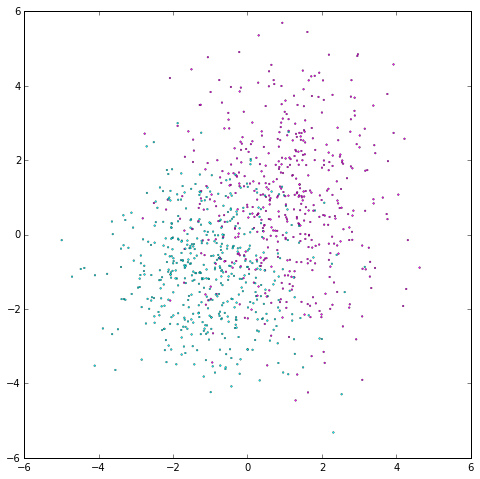

In [29]:
# Training data - two randomly-generated Gaussian-distributed clouds of points in 2d space
np.random.seed(0)
# Number of points
N = 1000
# Labels for each cluster
y = np.random.random_integers(0, 1, N)
# Mean of each cluster
means = np.array([[-1, 1], [-1, 1]])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 2)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]])
# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(X[0, :], X[1, :], c=y, lw=.3, s=3, cmap=plt.cm.cool)
plt.axis([-6, 6, -6, 6])
plt.show()

In [30]:
# First, set the size of each layer (and the number of layers)
# Input layer size is training data dimensionality (2)
# Output size is just 1-d: class label - 0 or 1
# Finally, let the hidden layers be twice the size of the input.
# If we wanted more layers, we could just add another layer size to this list.
layer_sizes = [X.shape[0], X.shape[0]*2, 1]
# Set initial parameter values
W_init = []
b_init = []
activations = []
for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
    # Getting the correct initialization matters a lot for non-toy problems.
    # However, here we can just use the following initialization with success:
    # Normally distribute initial weights
    W_init.append(np.random.randn(n_output, n_input))
    # Set initial biases to 1
    b_init.append(np.ones(n_output))
    # We'll use sigmoid activation for all layers
    # Note that this doesn't make a ton of sense when using squared distance
    # because the sigmoid function is bounded on [0, 1].
    activations.append(T.nnet.sigmoid)
# Create an instance of the MLP class
mlp = MLP(W_init, b_init, activations)

# Create Theano variables for the MLP input
mlp_input = T.matrix('mlp_input')
# ... and the desired output
mlp_target = T.vector('mlp_target')
# Learning rate and momentum hyperparameter values
# Again, for non-toy problems these values can make a big difference
# as to whether the network (quickly) converges on a good local minimum.
learning_rate = 0.01
momentum = 0.9
# Create a function for computing the cost of the network given an input
cost = mlp.squared_error(mlp_input, mlp_target)
# Create a theano function for training the network
train = theano.function([mlp_input, mlp_target], cost,
                        updates=gradient_updates_momentum(cost, mlp.params, learning_rate, momentum))
# Create a theano function for computing the MLP's output given some input
mlp_output = theano.function([mlp_input], mlp.output(mlp_input))

In [31]:
# Keep track of the number of training iterations performed
iteration = 0
# We'll only train the network with 20 iterations.
# A more common technique is to use a hold-out validation set.
# When the validation error starts to increase, the network is overfitting,
# so we stop training the net.  This is called "early stopping", which we won't do here.
max_iteration = 20
while iteration < max_iteration:
    # Train the network using the entire training set.
    # With large datasets, it's much more common to use stochastic or mini-batch gradient descent
    # where only a subset (or a single point) of the training set is used at each iteration.
    # This can also help the network to avoid local minima.
    current_cost = train(X, y)
    # Get the current network output for all points in the training set
    current_output = mlp_output(X)
    # We can compute the accuracy by thresholding the output
    # and computing the proportion of points whose class match the ground truth class.
    accuracy = np.mean((current_output > .5) == y)
    # Plot network output after this iteration
    plt.figure(figsize=(8, 8))
    plt.scatter(X[0, :], X[1, :], c=current_output,
                lw=.3, s=3, cmap=plt.cm.cool, vmin=0, vmax=1)
    plt.axis([-6, 6, -6, 6])
    plt.title('Cost: {:.3f}, Accuracy: {:.3f}'.format(float(current_cost), accuracy))
    plt.show()
    iteration += 1

TypeError: ('Bad input argument to theano function with name "<ipython-input-30-005c783df027>:38"  at index 0(0-based)', 'TensorType(float32, matrix) cannot store a value of dtype float64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to float32, or 2) set "allow_input_downcast=True" when calling "function".', array([[-0.2566337 ,  0.69425932,  0.51472589, ..., -1.01075807,
         0.28242532,  0.36669784],
       [-0.36852293,  0.11203788,  1.27076249, ..., -1.45973637,
         0.55144031,  0.30790906]]))